In [ ]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

In [ ]:
!pip install pytorchvideo transformers evaluate -q

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [47]:
!git config --global credential.helper store

In [48]:
from transformers.utils import send_example_telemetry

send_example_telemetry("video_classification_notebook", framework="pytorch")

In [49]:
from huggingface_hub import hf_hub_download


hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

In [50]:
!tar xf {file_path}

In [51]:
dataset_root_path = "ASD_eye_contact/"

!find {dataset_root_path} | head -5

'head' is not recognized as an internal or external command,
operable program or batch file.


In [52]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)
print(dataset_root_path)

ASD_eye_contact


In [53]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 14


In [54]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_01.mp4'),
 WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_02.mp4'),
 WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_03.mp4'),
 WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_04.mp4'),
 WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_01.mp4')]

In [55]:
print(all_video_file_paths)

[WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_01.mp4'), WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_02.mp4'), WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_03.mp4'), WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_04.mp4'), WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_01.mp4'), WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_02.mp4'), WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_03.mp4'), WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_04.mp4'), WindowsPath('ASD_eye_contact/val/ASD_eye_contact/ASD_eye_05.mp4'), WindowsPath('ASD_eye_contact/val/ASD_eye_contact/ASD_eye_06.mp4'), WindowsPath('ASD_eye_contact/val/Non_asd_eye_contact/Non_asd_eye_05.mp4'), WindowsPath('ASD_eye_contact/val/Non_asd_eye_contact/Non_asd_eye_06.mp4'), WindowsPath('ASD_eye_contact/test/ASD_eye_contact/ASD_eye_07.mp4'), WindowsPath('ASD_eye_contact/test/Non_asd_eye_contact/Non_asd_e

In [56]:

class_labels = sorted({str(path).split("\\")[2] for path in all_video_file_paths})

print(all_video_file_paths)
print(f"Unique classes: {class_labels}.")
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

[WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_01.mp4'), WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_02.mp4'), WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_03.mp4'), WindowsPath('ASD_eye_contact/train/ASD_eye_contact/ASD_eye_04.mp4'), WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_01.mp4'), WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_02.mp4'), WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_03.mp4'), WindowsPath('ASD_eye_contact/train/Non_asd_eye_contact/Non_asd_eye_04.mp4'), WindowsPath('ASD_eye_contact/val/ASD_eye_contact/ASD_eye_05.mp4'), WindowsPath('ASD_eye_contact/val/ASD_eye_contact/ASD_eye_06.mp4'), WindowsPath('ASD_eye_contact/val/Non_asd_eye_contact/Non_asd_eye_05.mp4'), WindowsPath('ASD_eye_contact/val/Non_asd_eye_contact/Non_asd_eye_06.mp4'), WindowsPath('ASD_eye_contact/test/ASD_eye_contact/ASD_eye_07.mp4'), WindowsPath('ASD_eye_contact/test/Non_asd_eye_contact/Non_asd_e

In [1]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

NameError: name 'model_ckpt' is not defined

In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [ ]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 40
fps = 60
clip_duration = num_frames_to_sample * sample_rate / fps
print(clip_duration)


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

10.666666666666666


In [ ]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(8, 4, 2)

In [ ]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [ ]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name Non_asd_eye_03.mp4
video_index 6
clip_index 0
aug_index 0
label 1
Video label: Non_asd_eye_contact


Visualize the preprocessed videos for easier debugging.

In [ ]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

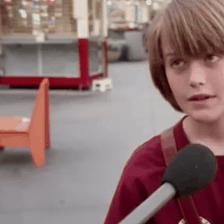

In [ ]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

### Training the model

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-ASD_Eye_Contact_v2"
print(new_model_name)
num_epochs = 10

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

KeyboardInterrupt: 

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
train_results = trainer.train()

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.5182222723960876, 'eval_accuracy': 1.0, 'eval_runtime': 10.8329, 'eval_samples_per_second': 0.369, 'eval_steps_per_second': 0.092, 'epoch': 0.1}
{'eval_loss': 0.38720089197158813, 'eval_accuracy': 1.0, 'eval_runtime': 13.8765, 'eval_samples_per_second': 0.288, 'eval_steps_per_second': 0.072, 'epoch': 1.1}
{'eval_loss': 0.2653670310974121, 'eval_accuracy': 1.0, 'eval_runtime': 13.7, 'eval_samples_per_second': 0.292, 'eval_steps_per_second': 0.073, 'epoch': 2.1}
{'eval_loss': 0.18419551849365234, 'eval_accuracy': 1.0, 'eval_runtime': 13.6849, 'eval_samples_per_second': 0.292, 'eval_steps_per_second': 0.073, 'epoch': 3.1}
{'eval_loss': 0.13043838739395142, 'eval_accuracy': 1.0, 'eval_runtime': 13.6046, 'eval_samples_per_second': 0.294, 'eval_steps_per_second': 0.074, 'epoch': 4.1}
{'eval_loss': 0.09366782009601593, 'eval_accuracy': 1.0, 'eval_runtime': 18.3462, 'eval_samples_per_second': 0.218, 'eval_steps_per_second': 0.055, 'epoch': 5.1}
{'eval_loss': 0.0732516497373581,

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.5593659281730652,
 'eval_accuracy': 1.0,
 'eval_runtime': 11.9127,
 'eval_samples_per_second': 0.168,
 'eval_steps_per_second': 0.084,
 'epoch': 9.1}

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

events.out.tfevents.1718458633.DESKTOP-SGO0ICV.160328.2:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1718459458.DESKTOP-SGO0ICV.160328.3:   0%|          | 0.00/405 [00:00<?, ?B/s]

***** test metrics *****
  epoch                   =        9.1
  eval_accuracy           =        1.0
  eval_loss               =     0.5594
  eval_runtime            = 0:00:09.87
  eval_samples_per_second =      0.202
  eval_steps_per_second   =      0.101


In [ ]:
trainer.push_to_hub()

events.out.tfevents.1718459458.DESKTOP-SGO0ICV.160328.3:   0%|          | 0.00/722 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kanlo/videomae-base-ASD_Eye_Contact_v2/commit/51e61ce81b83c45181f0b00eca23514379a08159', commit_message='End of training', commit_description='', oid='51e61ce81b83c45181f0b00eca23514379a08159', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained('videomae-base-ASD_Eye_Contact_v2')

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name Non_asd_eye_07.mp4
video_index 1
clip_index 0
aug_index 0
label 1
Video label: Non_asd_eye_contact


In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])

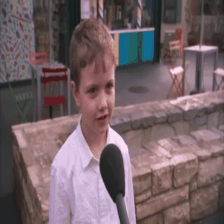

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()

print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Non_asd_eye_contact
